In [3]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

from datetime import datetime
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## ASV metrics

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score


In [6]:
def obtain_asv_error_rates(tar_asv, non_asv, spoof_asv, asv_threshold):

    # False alarm and miss rates for ASV
    Pfa_asv = sum(non_asv >= asv_threshold) / non_asv.size
    Pmiss_asv = sum(tar_asv < asv_threshold) / tar_asv.size

    # Rate of rejecting spoofs in ASV
    if spoof_asv.size == 0:
        Pmiss_spoof_asv = None
    else:
        Pmiss_spoof_asv = np.sum(spoof_asv < asv_threshold) / spoof_asv.size

    return Pfa_asv, Pmiss_asv, Pmiss_spoof_asv


def compute_det_curve(target_scores, nontarget_scores):

    n_scores = target_scores.size + nontarget_scores.size
    all_scores = np.concatenate((target_scores, nontarget_scores))
    labels = np.concatenate((np.ones(target_scores.size), np.zeros(nontarget_scores.size)))

    # Sort labels based on scores
    indices = np.argsort(all_scores, kind='mergesort')
    labels = labels[indices]

    # Compute false rejection and false acceptance rates
    tar_trial_sums = np.cumsum(labels)
    nontarget_trial_sums = nontarget_scores.size - (np.arange(1, n_scores + 1) - tar_trial_sums)

    frr = np.concatenate((np.atleast_1d(0), tar_trial_sums / target_scores.size))  # false rejection rates
    far = np.concatenate((np.atleast_1d(1), nontarget_trial_sums / nontarget_scores.size))#false acceptance rates
    thresholds = np.concatenate((
        np.atleast_1d(all_scores[indices[0]] - 0.001), all_scores[indices]))  # Thresholds are the sorted scores

    return frr, far, thresholds

def compute_eer(target_scores, nontarget_scores):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    frr, far, thresholds = compute_det_curve(target_scores, nontarget_scores)
    abs_diffs = np.abs(frr - far)
    min_index = np.argmin(abs_diffs)
    eer = np.mean((frr[min_index], far[min_index]))
    return eer, thresholds[min_index]

### Extract train features

In [7]:
X_train_bonafide_list = []
X_train_spoof_list = []
max_lpc_order = 50
lpc_lengths = np.arange(1, max_lpc_order + 1)


for l in lpc_lengths:
    train_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/lpc/train_LPC_' + str(l) +'.pkl')
    #train_features.drop('coeff', axis=1, inplace=True)
    train_features.dropna(inplace=True)
    
    train_bonafide_features = train_features[train_features['label']=='bonafide']
    train_spoof_features = train_features[train_features['label']=='spoof']
    
    if l==1:
        train_spoof_features = train_features[train_features['label']=='spoof'].sample(
            n=train_bonafide_features.shape[0])
        selected_files = train_spoof_features['audio_filename']
    else:
        train_spoof_features = train_spoof_features[train_spoof_features['audio_filename'].isin(selected_files)]
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_res_mean']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_res_max']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_res_min']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_res_var']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_gain_max']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_gain_min']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_gain_mean']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_gain_var']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_res_mean']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_res_max']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_res_min']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_res_var']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_gain_max']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_gain_min']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_gain_mean']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_gain_var']).reshape((-1, 1)))


    X_train_spoof_list.append(np.array(train_spoof_features['lpc_res_mean']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_res_max']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_res_min']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_res_var']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_gain_max']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_gain_min']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_gain_mean']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_gain_var']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_res_mean']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_res_max']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_res_min']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_res_var']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_gain_max']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_gain_min']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_gain_mean']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_gain_var']).reshape((-1, 1)))





In [8]:
X_train_bonafide = np.concatenate(X_train_bonafide_list, axis=1)
X_train_spoof = np.concatenate(X_train_spoof_list, axis=1)
X_train = np.concatenate((X_train_bonafide, X_train_spoof), axis=0)

y_train_bonafide = np.zeros((X_train_bonafide.shape[0],))
y_train_spoof = np.ones((X_train_spoof.shape[0],))

y_train = np.concatenate((y_train_bonafide, y_train_spoof), axis=0)

### Extract dev features

In [9]:
X_dev_bonafide_list = []
X_dev_spoof_list = []

for l in lpc_lengths:
    dev_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/lpc/dev_LPC_' + str(l) +'.pkl')
    #dev_features.drop('coeff', axis=1, inplace=True)
    dev_features.dropna(inplace=True)  
    
    dev_bonafide_features = dev_features[dev_features['label']=='bonafide']
    dev_spoof_features = dev_features[dev_features['label']=='spoof']
    
    if l==1:
        dev_spoof_features = dev_features[dev_features['label']=='spoof'].sample(n=dev_bonafide_features.shape[0])
        selected_files = dev_spoof_features['audio_filename']
    else:
        dev_spoof_features = dev_spoof_features[dev_spoof_features['audio_filename'].isin(selected_files)]
    
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_res_mean']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_res_max']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_res_min']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_res_var']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_gain_max']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_gain_min']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_gain_mean']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_gain_var']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_res_mean']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_res_max']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_res_min']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_res_var']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_gain_max']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_gain_min']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_gain_mean']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_gain_var']).reshape((-1, 1)))
    
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_res_mean']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_res_max']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_res_min']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_res_var']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_gain_max']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_gain_min']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_gain_mean']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_gain_var']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_res_mean']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_res_max']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_res_min']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_res_var']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_gain_max']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_gain_min']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_gain_mean']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_gain_var']).reshape((-1, 1)))

In [10]:
X_dev_bonafide = np.concatenate(X_dev_bonafide_list, axis=1)
X_dev_spoof = np.concatenate(X_dev_spoof_list, axis=1)
X_dev = np.concatenate((X_dev_bonafide, X_dev_spoof), axis=0)

y_dev_bonafide = np.zeros((X_dev_bonafide.shape[0],))
y_dev_spoof = np.ones((X_dev_spoof.shape[0],))

y_dev = np.concatenate((y_dev_bonafide, y_dev_spoof), axis=0)

### Extract eval features

In [11]:
X_eval_bonafide_list = []
X_eval_spoof_list = []

for l in lpc_lengths:
    eval_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/lpc/eval_LPC_' + str(l) +'.pkl')
    #eval_features = eval_features[~eval_features['audio_filename'].isin(excluded_files)]
    #eval_features.drop('coeff', axis=1, inplace=True)
    eval_features.dropna(inplace=True)

    eval_bonafide_features = eval_features[eval_features['label']=='bonafide']
    eval_spoof_features= eval_features[eval_features['label']=='spoof']
    
    if l==1:
        eval_spoof_features = eval_features[eval_features['label']=='spoof'].sample(
            n=eval_bonafide_features.shape[0])
        selected_files = eval_spoof_features['audio_filename']
    else:
        eval_spoof_features = eval_spoof_features[eval_spoof_features['audio_filename'].isin(selected_files)]
    
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_res_mean']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_res_max']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_res_min']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_res_var']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_gain_max']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_gain_min']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_gain_mean']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_gain_var']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_res_mean']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_res_max']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_res_min']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_res_var']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_gain_max']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_gain_min']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_gain_mean']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_gain_var']).reshape((-1, 1)))

    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_res_mean']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_res_max']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_res_min']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_res_var']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_gain_max']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_gain_min']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_gain_mean']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_gain_var']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_res_mean']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_res_max']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_res_min']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_res_var']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_gain_max']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_gain_min']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_gain_mean']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_gain_var']).reshape((-1, 1)))

In [12]:
X_eval_bonafide = np.concatenate(X_eval_bonafide_list, axis=1)
X_eval_spoof = np.concatenate(X_eval_spoof_list, axis=1)
X_eval = np.concatenate((X_eval_bonafide, X_eval_spoof), axis=0)

y_eval_bonafide = np.zeros((X_eval_bonafide.shape[0],))
y_eval_spoof = np.ones((X_eval_spoof.shape[0],))

y_eval = np.concatenate((y_eval_bonafide, y_eval_spoof), axis=0)

## Reshape data for CNN

In [13]:
n_features = 16
lpc_lenght = 50
reshaped_X_train = np.zeros([X_train.shape[0], n_features, lpc_lenght ])
for n in np.arange(X_train.shape[0]):
    for i in np.arange(n_features):
        reshaped_X_train[n, i, :] = X_train[n, i::n_features]

print(reshaped_X_train.shape)

(5036, 16, 50)


In [14]:
n_features = 16
lpc_lenght = 50
reshaped_X_eval = np.zeros([X_eval.shape[0], n_features, lpc_lenght ])
for n in np.arange(X_eval.shape[0]):
    for i in np.arange(n_features):
        reshaped_X_eval[n, i, :] = X_eval[n, i::n_features]

print(reshaped_X_eval.shape)

(14080, 16, 50)


In [15]:
n_features = 16
lpc_lenght = 50
reshaped_X_dev = np.zeros([X_dev.shape[0], n_features, lpc_lenght ])
for n in np.arange(X_dev.shape[0]):
    for i in np.arange(n_features):
        reshaped_X_dev[n, i, :] = X_dev[n, i::n_features]

print(reshaped_X_dev.shape)

(4834, 16, 50)


## Normalize features

In [17]:
import sklearn.preprocessing

feature_list = ['lpc_res_mean', 'lpc_res_max', 'lpc_res_min', 
                'lpc_res_var', 'lpc_gain_max', 'lpc_gain_min', 'lpc_gain_mean', 'lpc_gain_var',
                'ltp_res_mean', 'ltp_res_max', 'ltp_res_min', 
                'ltp_res_var', 'ltp_gain_max', 'ltp_gain_min', 'ltp_gain_mean', 'ltp_gain_var']

n_features = 16
lpc_lenght = 50
norm_X_train = np.zeros(reshaped_X_train.shape)
feature_index = 1

for feature_index in np.arange(n_features):
    norm_X_train[:, feature_index, :] = sklearn.preprocessing.normalize(reshaped_X_train[:, feature_index, :])


In [18]:
norm_X_dev = np.zeros(reshaped_X_dev.shape)

for feature_index in np.arange(n_features):
    norm_X_dev[:, feature_index, :] = sklearn.preprocessing.normalize(reshaped_X_dev[:, feature_index, :])


In [19]:
norm_X_eval = np.zeros(reshaped_X_eval.shape)

for feature_index in np.arange(n_features):
    norm_X_eval[:, feature_index, :] = sklearn.preprocessing.normalize(reshaped_X_eval[:, feature_index, :])


## Train tutorial CNN

In [20]:
logdir = "logs/scalars/model1_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)

In [21]:
batch_size = 128
num_classes = 2
epochs = 12


# convert class vectors to binary class matrices
y_train_cat = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_dev_cat = tensorflow.keras.utils.to_categorical(y_dev, num_classes)



In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=[16, 50, 1]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 46, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 23, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 23, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8832)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1130624   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [23]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])

reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)

training_history = model.fit(np.expand_dims(norm_X_train, axis=3), y_train_cat,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
         callbacks=[reduce_lr, tensorboard_callback])

print("Average test loss: ", np.average(training_history.history['loss']))


Train on 5036 samples
Epoch 1/12
5036/5036 [==============================] - 5s 991us/sample - loss: 0.6081 - accuracy: 0.6692
Epoch 2/12
5036/5036 [==============================] - 0s 49us/sample - loss: 0.4488 - accuracy: 0.7971
Epoch 3/12
5036/5036 [==============================] - 0s 45us/sample - loss: 0.3365 - accuracy: 0.8660
Epoch 4/12
5036/5036 [==============================] - 0s 39us/sample - loss: 0.2825 - accuracy: 0.8932
Epoch 5/12
5036/5036 [==============================] - 0s 40us/sample - loss: 0.2614 - accuracy: 0.9015
Epoch 6/12
5036/5036 [==============================] - 0s 39us/sample - loss: 0.2323 - accuracy: 0.9069
Epoch 7/12
5036/5036 [==============================] - 0s 40us/sample - loss: 0.2328 - accuracy: 0.9104
Epoch 8/12
5036/5036 [==============================] - 0s 40us/sample - loss: 0.2068 - accuracy: 0.9186
Epoch 9/12
5036/5036 [==============================] - 0s 40us/sample - loss: 0.1964 - accuracy: 0.9214
Epoch 10/12
5036/5036 [=========

In [24]:
score = model.evaluate(np.expand_dims(norm_X_dev, axis=3), y_dev_cat, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18720942192060128
Test accuracy: 0.92863053


## Test model bot by bot on dev

In [25]:
bot_reshaped_X_dev_bonafide = np.zeros([X_dev_bonafide.shape[0], n_features, lpc_lenght ])

for n in np.arange(X_dev_bonafide.shape[0]):
    for i in np.arange(n_features):
        bot_reshaped_X_dev_bonafide[n, i, :] = X_dev_bonafide[n, i::n_features]

bot_norm_X_dev_bonafide = np.zeros(bot_reshaped_X_dev_bonafide.shape)

for feature_index in np.arange(n_features):
    bot_norm_X_dev_bonafide[:, feature_index, :] = sklearn.preprocessing.normalize(bot_reshaped_X_dev_bonafide
                                                                       [:, feature_index, :])

bot_y_dev_bonafide = np.zeros(bot_norm_X_dev_bonafide.shape[0])

In [27]:
dev_bot_names = {'A01':'WaveNet*', 'A02':'WORLD' ,
                          'A03':'WORLD', 'A04':'Waveform concat.', 
                          'A05':'WORLD', 'A06':'Spectral filtering + OLA'}

bot_X_dev_bonafide_list = []
bot_X_dev_spoof_list = []

dev_bot_systems = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06']

lpc_lengths = np.arange(1, 51)

dev_bot_features = []

for b in dev_bot_systems:
    bot_X_dev_spoof_list = []
    selected_files = []
    for l in lpc_lengths:
        bot_dev_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/lpc/bot/dev_LPC_' + 
                                      str(l) +'_bot_'+ str(b) +'.pkl')

        #dev_features.drop('coeff', axis=1, inplace=True)

        bot_dev_features.dropna(inplace=True)

        bot_dev_bonafide_features = bot_dev_features[bot_dev_features['label']=='bonafide']
        bot_dev_spoof_features = bot_dev_features[bot_dev_features['label']=='spoof'] 
        
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['lpc_res_mean']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['lpc_res_max']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['lpc_res_min']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['lpc_res_var']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['lpc_gain_max']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['lpc_gain_min']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['lpc_gain_mean']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['lpc_gain_var']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['ltp_res_mean']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['ltp_res_max']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['ltp_res_min']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['ltp_res_var']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['ltp_gain_max']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['ltp_gain_min']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['ltp_gain_mean']).reshape((-1, 1)))
        bot_X_dev_spoof_list.append(np.array(bot_dev_spoof_features['ltp_gain_var']).reshape((-1, 1)))
    bot_X_dev_spoof = np.concatenate(bot_X_dev_spoof_list, axis=1)

    
    bot_reshaped_X_dev_spoof = np.zeros([bot_X_dev_spoof.shape[0], n_features, lpc_lenght ])
    for n in np.arange(bot_X_dev_spoof.shape[0]):
        for i in np.arange(n_features):
            bot_reshaped_X_dev_spoof[n, i, :] = bot_X_dev_spoof[n, i::n_features]
    
    bot_norm_X_dev_spoof = np.zeros(bot_reshaped_X_dev_spoof.shape)

    for feature_index in np.arange(n_features):
        bot_norm_X_dev_spoof[:, feature_index, :] = sklearn.preprocessing.normalize(bot_reshaped_X_dev_spoof
                                                                           [:, feature_index, :])

    bot_y_dev_spoof = np.ones((bot_X_dev_spoof.shape[0],))

    dev_bot_features.append({'bot': b, 'X_dev_spoof':bot_norm_X_dev_spoof, 'y_dev_spoof': bot_y_dev_spoof})


Bot system WaveNet*
ROC AUC score: 0.8591953584701493
Accuracy: 0.7985019032458163
Equal error rate: 0.2185151379950796


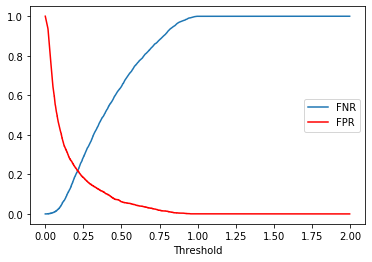

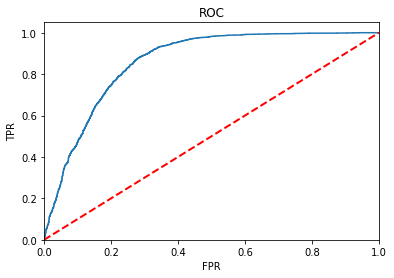



Bot system WORLD
ROC AUC score: 0.9899565865278788
Accuracy: 0.9530923599434369
Equal error rate: 0.050100668085739014


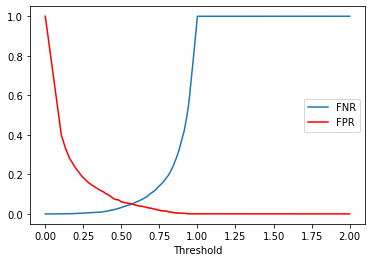

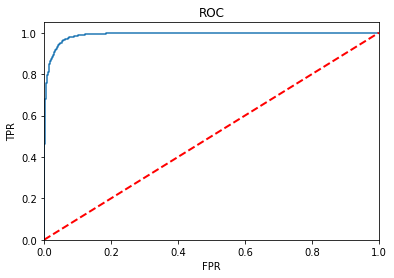



Bot system WORLD
ROC AUC score: 0.9996070426047093
Accuracy: 0.9928030708305993
Equal error rate: 0.007815065042886656


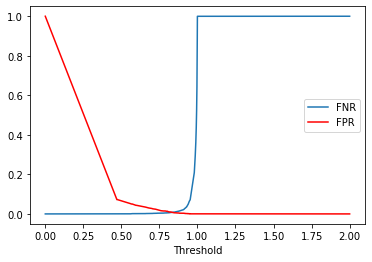

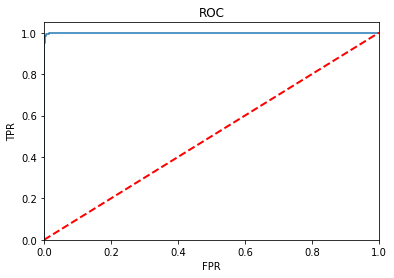



Bot system Waveform concat.
ROC AUC score: 0.732872766277491
Accuracy: 0.6802148126239372
Equal error rate: 0.3259630103720432


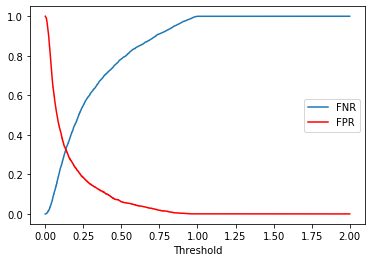

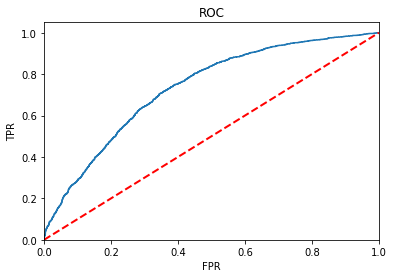



Bot system WORLD
ROC AUC score: 0.9973481665024302
Accuracy: 0.9779998414795669
Equal error rate: 0.02391960926433787


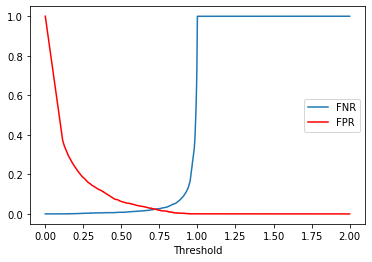

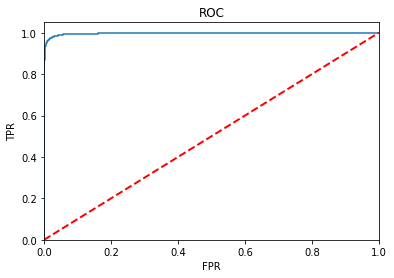



Bot system Spectral filtering + OLA
ROC AUC score: 0.7667180577597463
Accuracy: 0.7123523649622984
Equal error rate: 0.2966107151000845


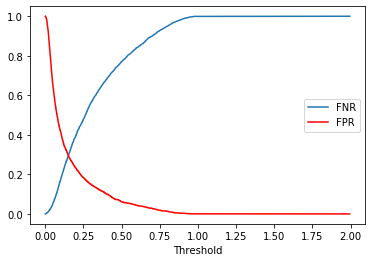

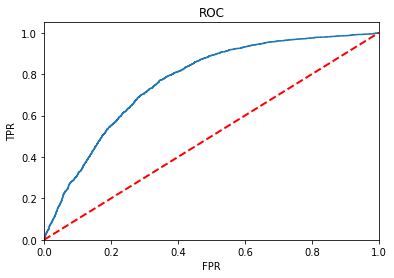

In [56]:
for b in dev_bot_systems:
    bot_X_dev_spoof = [d['X_dev_spoof'] for d in dev_bot_features if d['bot'] == b][0]
    bot_y_dev_spoof = [d['y_dev_spoof'] for d in dev_bot_features if d['bot'] == b][0]
    
    bot_X_dev = np.concatenate((bot_norm_X_dev_bonafide, bot_X_dev_spoof), axis=0)
    bot_y_dev = np.concatenate((bot_y_dev_bonafide, bot_y_dev_spoof), axis=0)
    
    
    bot_y_dev_hat = model.predict(np.expand_dims(bot_X_dev, axis=3))[:,1]

    
    [fpr, tpr, th] = roc_curve(bot_y_dev, bot_y_dev_hat, pos_label=1)
    fnr = 1-tpr
    roc_auc = roc_auc_score(bot_y_dev, bot_y_dev_hat)
    print('Bot system %s' %dev_bot_names[b])

    print('ROC AUC score: {}'.format(roc_auc))
    
    acc = (tpr + (1-fpr)) / 2
    best_th = th[np.where(acc == np.max(acc))][0]
    #print('Best threshold: {}'.format(best_th))
    print('Accuracy: {}'.format(acc.max()))
    
    bot_target_score = bot_y_dev_hat[np.where(bot_y_dev==1)]
    bot_nontarget_score = bot_y_dev_hat[np.where(bot_y_dev==0)]

    eer, _ = compute_eer(bot_target_score, bot_nontarget_score)
    print('Equal error rate: {}'.format(eer))
    
    plt.figure()
    plt.plot(th, fnr)
    plt.plot(th, fpr, color='red')
    plt.xlabel('Threshold')
    plt.legend(['FNR', 'FPR'])
    #plt.plot(th, np.abs(fnr-fpr))
    plt.show()
    
    plt.figure()
    plt.title('ROC')
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()
    
    print('\n')

# Train on train and dev, test on eval

In [29]:
logdir = "logs/scalars/model2_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
X_bonafide = np.concatenate((X_train_bonafide, X_dev_bonafide), axis=0)
X_spoof = np.concatenate((X_train_spoof, X_dev_spoof), axis=0)
                
X = np.concatenate((X_bonafide, X_spoof), axis=0)

In [31]:
y_bonafide = np.zeros([X_bonafide.shape[0],])
y_spoof = np.ones([X_spoof.shape[0],])

y = np.concatenate((y_bonafide, y_spoof), axis=0)

In [32]:
n_features = 16
lpc_lenght = 50
reshaped_X = np.zeros([X.shape[0], n_features, lpc_lenght ])
for n in np.arange(X.shape[0]):
    for i in np.arange(n_features):
        reshaped_X[n, i, :] = X[n, i::n_features]

print(reshaped_X.shape)

(9870, 16, 50)


In [33]:
norm_X = np.zeros(reshaped_X.shape)

for feature_index in np.arange(n_features):
    norm_X[:, feature_index, :] = sklearn.preprocessing.normalize(reshaped_X[:, feature_index, :])


In [34]:
y_cat = tensorflow.keras.utils.to_categorical(y, num_classes)
y_eval_cat = tensorflow.keras.utils.to_categorical(y_eval, num_classes)

In [35]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=[16, 50, 1]))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 48, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 23, 64)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 23, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8832)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1130624   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [36]:

model2.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])

reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)
model2.fit(np.expand_dims(norm_X, axis=3), y_cat,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Train on 9870 samples
Epoch 1/12
9870/9870 [==============================] - 1s 64us/sample - loss: 0.5652 - accuracy: 0.7019
Epoch 2/12
9870/9870 [==============================] - 0s 37us/sample - loss: 0.3467 - accuracy: 0.8554
Epoch 3/12
9870/9870 [==============================] - 0s 38us/sample - loss: 0.2732 - accuracy: 0.8925
Epoch 4/12
9870/9870 [==============================] - 0s 39us/sample - loss: 0.2498 - accuracy: 0.8997
Epoch 5/12
9870/9870 [==============================] - 0s 39us/sample - loss: 0.2167 - accuracy: 0.9174
Epoch 6/12
9870/9870 [==============================] - 0s 40us/sample - loss: 0.2089 - accuracy: 0.9180
Epoch 7/12
9870/9870 [==============================] - 0s 36us/sample - loss: 0.1967 - accuracy: 0.9217
Epoch 8/12
9870/9870 [==============================] - 0s 37us/sample - loss: 0.1768 - accuracy: 0.9344
Epoch 9/12
9870/9870 [==============================] - 0s 38us/sample - loss: 0.1816 - accuracy: 0.9306
Epoch 10/12
9870/9870 [==========

In [37]:
score = model2.evaluate(np.expand_dims(norm_X_eval, axis=3), y_eval_cat, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2978465791622346
Test accuracy: 0.88288355


## ASV scores on model2

[0.43846443]
0.8865056818181818


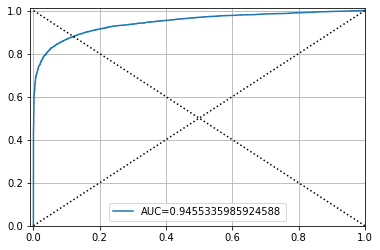

In [38]:
y_eval_hat = model2.predict(np.expand_dims(norm_X_eval, axis=3))[:,1]


[fpr, tpr, th] = roc_curve(y_eval, y_eval_hat, pos_label=1)
roc_auc = roc_auc_score(y_eval, y_eval_hat)

acc = (tpr + (1-fpr)) / 2
best_th = th[np.where(acc == np.max(acc))]
print(best_th)
print(acc.max())

plt.plot(fpr, tpr, label='AUC={}'.format(roc_auc))
plt.plot([0, 1], [0, 1], ':k')
plt.plot([1, 0], [0, 1], ':k')
plt.axis([-0.01, 1, 0, 1.01])
plt.grid(True)
plt.legend()
plt.show()

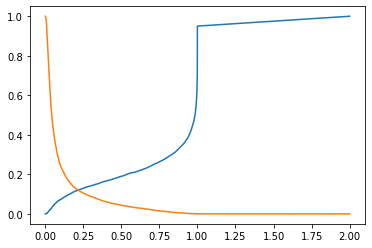

(0.12102272727272727, 0.21703515946865082)

In [39]:
target_score = y_eval_hat[np.where(y_eval==1)]
nontarget_score = y_eval_hat[np.where(y_eval==0)]

fnr = 1-tpr

plt.figure()
plt.plot(th, fnr)
plt.plot(th, fpr)
#plt.plot(th, np.abs(fnr-fpr))
plt.show()

compute_eer(target_score, nontarget_score)

## Eval model 2 bot by bot

In [40]:
bot_reshaped_X_eval_bonafide = np.zeros([X_eval_bonafide.shape[0], n_features, lpc_lenght ])
for n in np.arange(X_eval_bonafide.shape[0]):
    for i in np.arange(n_features):
        bot_reshaped_X_eval_bonafide[n, i, :] = X_eval_bonafide[n, i::n_features]

bot_norm_X_eval_bonafide = np.zeros(bot_reshaped_X_eval_bonafide.shape)

for feature_index in np.arange(n_features):
    bot_norm_X_eval_bonafide[:, feature_index, :] = sklearn.preprocessing.normalize(bot_reshaped_X_eval_bonafide
                                                                       [:, feature_index, :])

bot_y_eval_bonafide = np.zeros(bot_norm_X_eval_bonafide.shape[0])

In [42]:
bot_X_eval_spoof_list = []

eval_bot_systems = ['A11', 'A14', 'A16', 'A09', 'A13', 'A12', 'A18', 'A15', 'A08',
       'A17', 'A10', 'A07', 'A19']
eval_bot_names = {'A11':'Griffin-Lim', 'A14':'STRAIGHT' ,
                          'A16':'Waveform concat.', 'A09':'Vocaine', 
                          'A13':'Waveform filtering', 'A12':'WaveNet*',
                          'A18':'MFCC vocoder', 'A15':'WaveNet*', 
                          'A08':'Neural source-filter*','A17':'Waveform filtering',
                         'A10':'WaveRNN*', 'A07':'WORLD', 'A19': 'Spectral filtering + OLA'}


lpc_lengths = np.arange(1, 51)

eval_bot_features = []

for b in eval_bot_systems:
    bot_X_eval_spoof_list = []
    selected_files = []
    for l in lpc_lengths:
        bot_eval_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/lpc/bot/eval_LPC_' + 
                                       str(l) +'_bot_'+ str(b) +'.pkl')
        #eval_features.drop('coeff', axis=1, inplace=True)
        bot_eval_features.dropna(inplace=True)
        
        
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_res_mean']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_res_max']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_res_min']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_res_var']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_gain_max']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_gain_min']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_gain_mean']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_gain_var']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_res_mean']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_res_max']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_res_min']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_res_var']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_gain_max']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_gain_min']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_gain_mean']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_gain_var']).reshape((-1, 1)))

    bot_X_eval_spoof = np.concatenate(bot_X_eval_spoof_list, axis=1)
    
    n_features = 16
    lpc_lenght = 50
    
    bot_reshaped_X_eval_spoof = np.zeros([bot_X_eval_spoof.shape[0], n_features, lpc_lenght ])
    for n in np.arange(bot_X_eval_spoof.shape[0]):
        for i in np.arange(n_features):
            bot_reshaped_X_eval_spoof[n, i, :] = bot_X_eval_spoof[n, i::n_features]
    
    bot_norm_X_eval_spoof = np.zeros(bot_reshaped_X_eval_spoof.shape)

    for feature_index in np.arange(n_features):
        bot_norm_X_eval_spoof[:, feature_index, :] = sklearn.preprocessing.normalize(bot_reshaped_X_eval_spoof
                                                                           [:, feature_index, :])

    bot_y_eval_spoof = np.ones((bot_X_eval_spoof.shape[0],))
    

    eval_bot_features.append({'bot': b, 'X_eval_spoof': bot_norm_X_eval_spoof, 'y_eval_spoof': bot_y_eval_spoof})

Bot system Griffin-Lim
ROC AUC score: 0.9050928923319641
Accuracy: 0.8315040136135421
Equal error rate: 0.17047066936556132


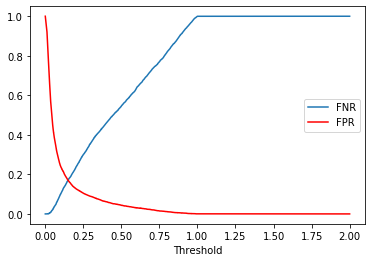

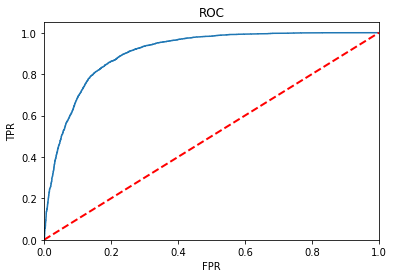



Bot system STRAIGHT
ROC AUC score: 0.987010259881015
Accuracy: 0.9488010003002778
Equal error rate: 0.05368391543427671


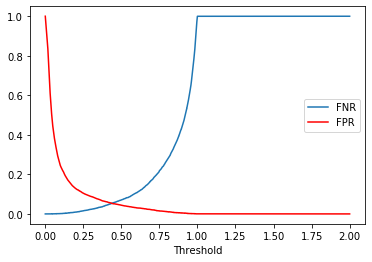

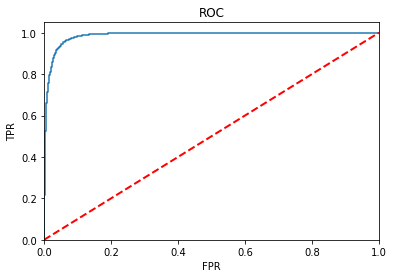



Bot system Waveform concat.
ROC AUC score: 0.7683702263362315
Accuracy: 0.7102166139271702
Equal error rate: 0.2934473332051813


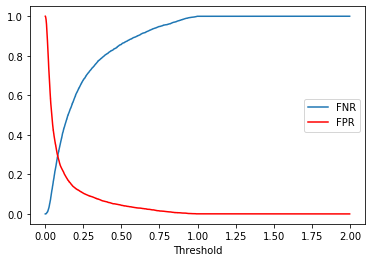

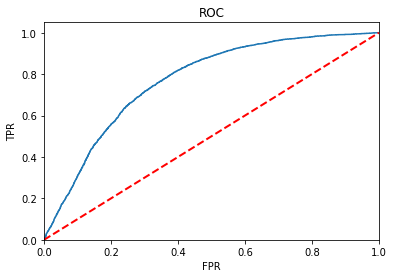



Bot system Vocaine
ROC AUC score: 0.997720943521787
Accuracy: 0.9849006103765214
Equal error rate: 0.015911260922400323


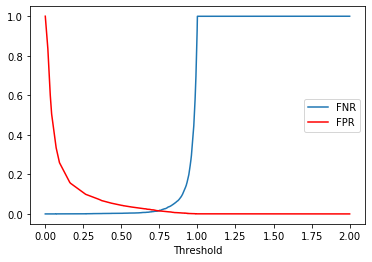

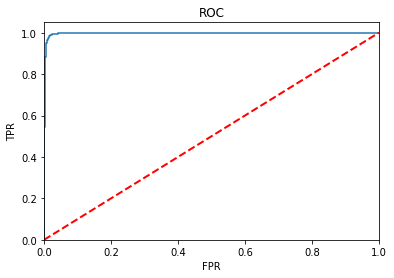



Bot system Waveform filtering
ROC AUC score: 0.9724694877230536
Accuracy: 0.9182107611089386
Equal error rate: 0.08378704051495256


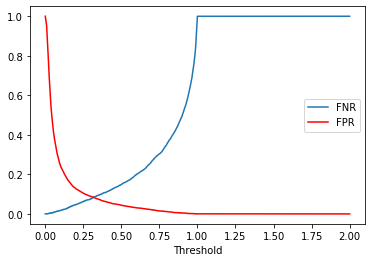

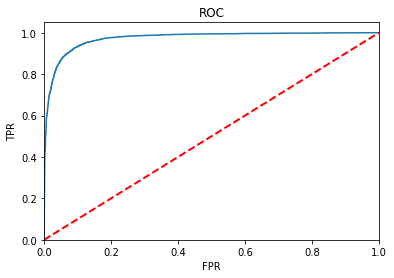



Bot system WaveNet*
ROC AUC score: 0.44099794219741156
Accuracy: 0.5018655395088278
Equal error rate: 0.5456434023890886


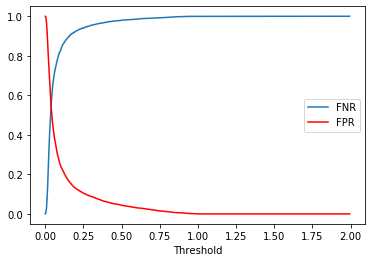

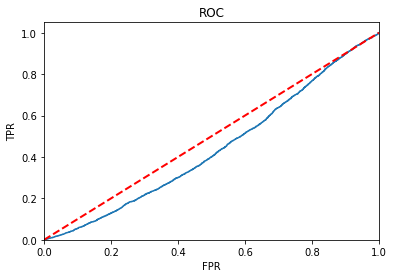



Bot system MFCC vocoder
ROC AUC score: 0.9327291142819696
Accuracy: 0.8616204225078639
Equal error rate: 0.13965728879460992


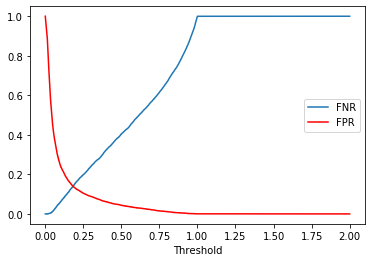

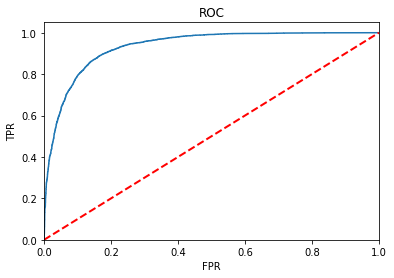



Bot system WaveNet*
ROC AUC score: 0.611577146687355
Accuracy: 0.5856612939548002
Equal error rate: 0.422293958926786


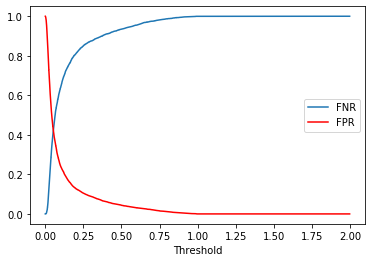

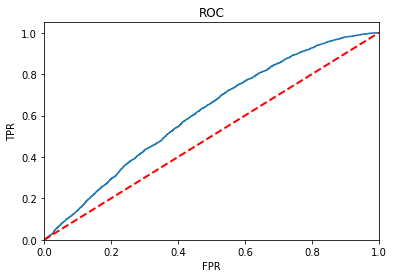



Bot system Neural source-filter*
ROC AUC score: 0.9863873209396452
Accuracy: 0.9463398959862703
Equal error rate: 0.05523587233641522


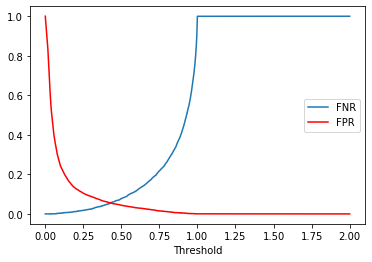

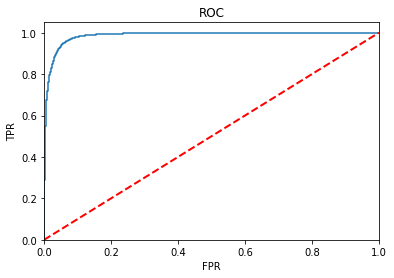



Bot system Waveform filtering
ROC AUC score: 0.6317230035424127
Accuracy: 0.6089568051865543
Equal error rate: 0.40791628162180893


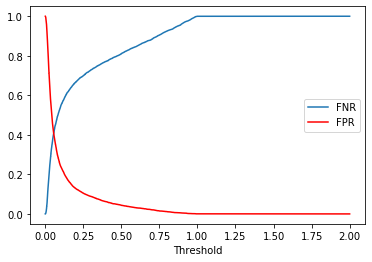

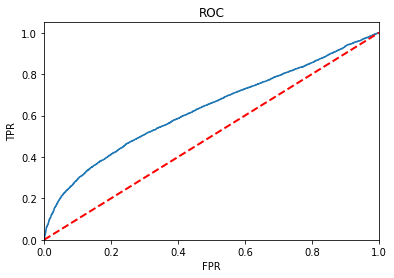



Bot system WaveRNN*
ROC AUC score: 0.5024415610391043
Accuracy: 0.5139147645763529
Equal error rate: 0.4958988489647078


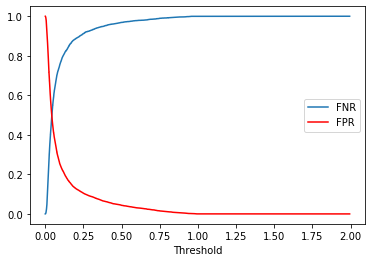

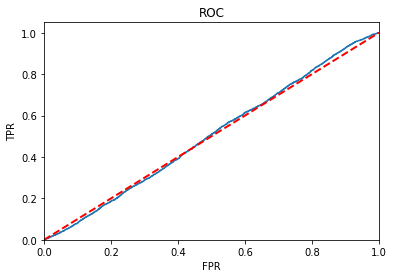



Bot system WORLD
ROC AUC score: 0.8231892655228596
Accuracy: 0.7625551649211834
Equal error rate: 0.24316292377456272


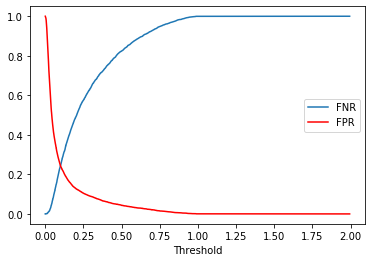

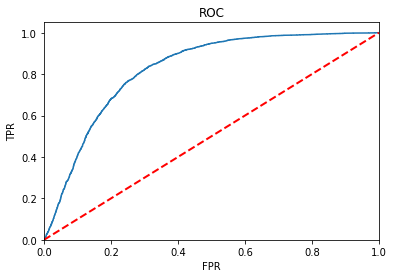



Bot system Spectral filtering + OLA
ROC AUC score: 0.8350778315671469
Accuracy: 0.7651153849839032
Equal error rate: 0.2382029213935306


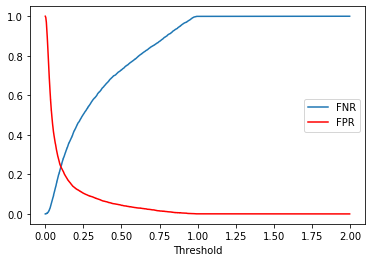

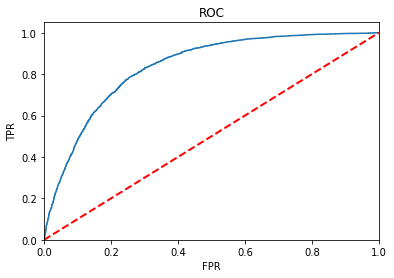

In [57]:
for b in eval_bot_systems:
    bot_X_eval_spoof = [d['X_eval_spoof'] for d in eval_bot_features if d['bot'] == b][0]
    bot_y_eval_spoof = [d['y_eval_spoof'] for d in eval_bot_features if d['bot'] == b][0]
    
    bot_X_eval = np.concatenate((bot_norm_X_eval_bonafide, bot_X_eval_spoof), axis=0)
    bot_y_eval = np.concatenate((bot_y_eval_bonafide, bot_y_eval_spoof), axis=0)
    
    
    bot_y_eval_hat = model2.predict(np.expand_dims(bot_X_eval, axis=3))[:,1]

    print('Bot system %s' %eval_bot_names[b])

    [fpr, tpr, th] = roc_curve(bot_y_eval, bot_y_eval_hat, pos_label=1)
    roc_auc = roc_auc_score(bot_y_eval, bot_y_eval_hat)
    print('ROC AUC score: {}'.format(roc_auc))
    
    fnr = 1 - tpr
    
    acc = (tpr + (1-fpr)) / 2
    best_th = th[np.where(acc == np.max(acc))][0]
    #print('Best threshold: {}'.format(best_th))
    print('Accuracy: {}'.format(acc.max()))
    
    
    bot_target_score = bot_y_eval_hat[np.where(bot_y_eval==1)]
    bot_nontarget_score = bot_y_eval_hat[np.where(bot_y_eval==0)]

    eer, _ = compute_eer(bot_target_score, bot_nontarget_score)
    print('Equal error rate: {}'.format(eer))
    
    plt.figure()
    plt.plot(th, fnr)
    plt.plot(th, fpr, color='red')
    plt.xlabel('Threshold')
    plt.legend(['FNR','FPR'])
    #plt.plot(th, np.abs(fnr-fpr))
    plt.show()
    
    plt.figure()
    plt.title('ROC')
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()
    print('\n')


In [ ]:
bot_y_eval_hat.shape

In [ ]:
bot_y_eval.shape

In [ ]:
bot_target_score = bot_y_eval_hat[np.where(y_eval==1)]